# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection and Tracking** 

## Import Packages

In [1]:
#importing some useful packages
from glob import glob
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import time
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm, grid_search
import pickle

from helper_functions import get_hog_features, bin_spatial, extract_features, slide_window, convert_color

%matplotlib inline

C:\Anaconda\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Load Classifier Parameters

In [2]:
classifier_params = pickle.load(open("classifier_params.pkl", "rb"))
svc = classifier_params['svc']
X_scaler = classifier_params['X_scaler']
orient = classifier_params['orient']
pix_per_cell = classifier_params['pix_per_cell']
cell_per_block = classifier_params['cell_per_block']
spatial_size = classifier_params['spatial_size']

## Find Cars In An Image

In [3]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size):
    
    #draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2GRAY')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    list_of_boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                pt1 = (xbox_left, ytop_draw+ystart)
                pt2 = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                #print(pt1, pt2)
                #cv2.rectangle(draw_img,pt1,pt2,(0,0,255),6) 
                list_of_boxes.append((pt1,pt2))
                
    #return draw_img, list_of_boxes
    return list_of_boxes

## Different Sized Windows

In [ ]:
test_image = glob('test_images/test3*.jpg')

img = mpimg.imread(test_image)

draw_img = np.copy(img)
img = img.astype(np.float32)/255

for scale in scales:
    if 0 != len(list_of_boxes):
        for box in list_of_boxes:
            pt1 = box[0]
            pt2 = box[1]
            #print(pt1, pt2, type(pt1), type(pt2))
            cv2.rectangle(draw_img,pt1,pt2,(0,0,255),6) 

plt.figure(image_num)
plt.imshow(draw_img)

C:\Anaconda\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


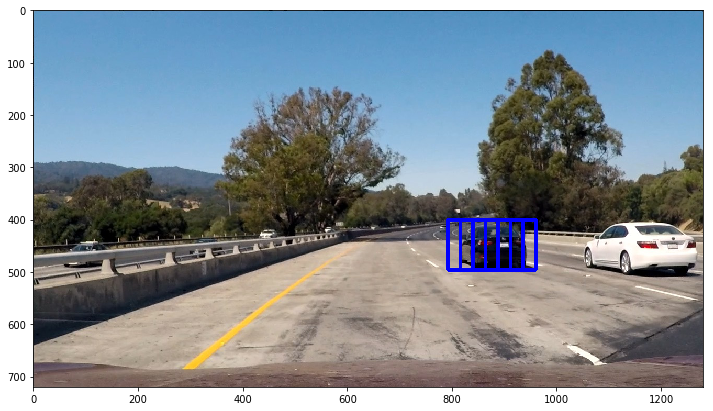

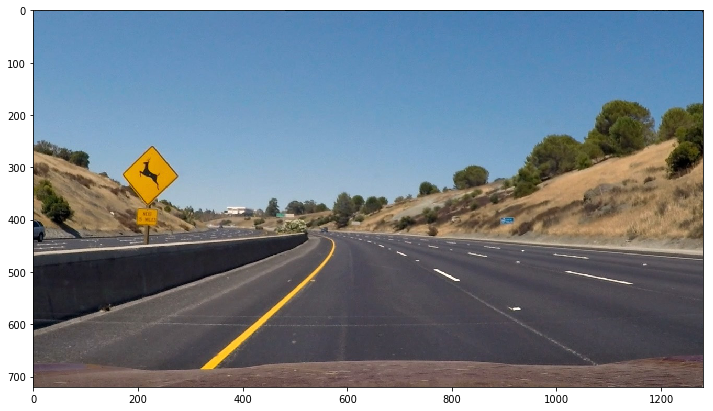

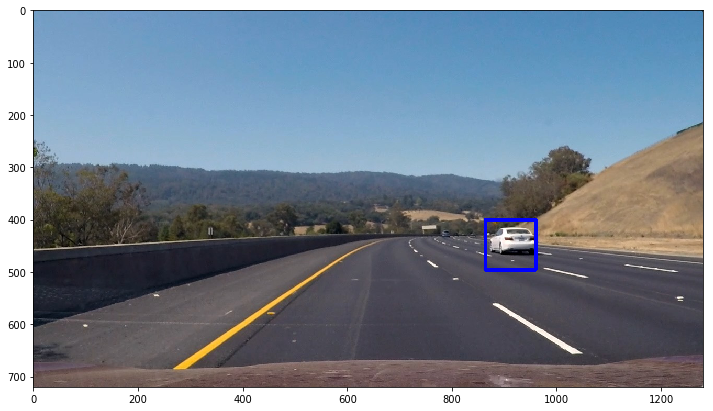

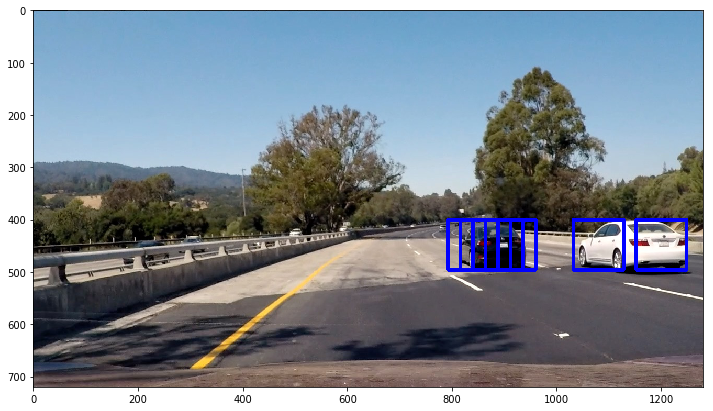

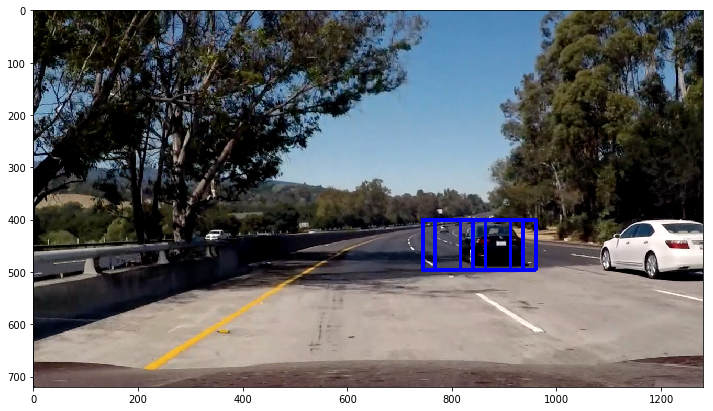

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [10]:
test_images = glob('test_images/*.jpg')

ystart = 400
ystop = 650
# Smaller scale numbers imply smaller box
#scales = [0.5, 1, 3, 3.5]
scales = [1.5, 2.1, 2.3]

image_num = 0
for image_path in test_images:
    image_num += 1
    img = mpimg.imread(image_path)
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    for scale in scales:        
        if scale < 1.8:
            y_start_new = ystart
            y_stop_new = int(ystart + (ystop - ystart)/2)
        else:            
            y_start_new = int(ystart + (ystop - ystart)/2)
            y_stop_new = ystop
            
        #print(y_start_new, y_stop_new)
        #out_img, list_of_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size)
        list_of_boxes = find_cars(img, y_start_new, y_stop_new, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size)
        
        if 0 != len(list_of_boxes):
            for box in list_of_boxes:
                pt1 = box[0]
                pt2 = box[1]
                #print(pt1, pt2, type(pt1), type(pt2))
                cv2.rectangle(draw_img,pt1,pt2,(0,0,255),6) 
    
    plt.figure(image_num, figsize = (12, 8))
    plt.imshow(draw_img)

## Splitting Data Into Training And Testing Set



In [ ]:
int(400 + (650-400)/2)

## Splitting Data Into Training And Testing Set



## Test pipeline on an image


In [ ]:
frame_number = 0
Left_Lane = Line()
Right_Lane = Line()
image = mpimg.imread('test_images/straight_lines1.jpg')
#image = mpimg.imread('test_images/test6.jpg')
#process_image(image)
#process_image(image)
#process_image(image)
#process_image(image)
#process_image(image)
#process_image(image)

## Test pipeline on video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
video_output = 'project_video_output.mp4'
#video_output = 'challenge_video_output.mp4'
#video_output = 'harder_challenge_video_output.mp4'


frame_number = 0
Left_Lane = Line()
Right_Lane = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
#clip1 = VideoFileClip("project_video.mp4").subclip(26,27)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("harder_challenge_video.mp4")
video_frame = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_frame.write_videofile(video_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))